In [16]:
import array
from glob import glob
import numpy as np
from scipy.spatial.distance import cdist, pdist
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "./../../DATA/vanhateren/vanhateren_imc/"
DATA_PATCHES = "./../../DATA/vanhateren/vanhateren_patches/"

# Test on one file

In [3]:
def load_image(filename):
    with open(filename, 'rb') as handle:
        s = handle.read()
    arr = array.array('H', s)
    arr.byteswap()
    img = np.array(arr, dtype='uint16').reshape(1024, 1536)
    return img

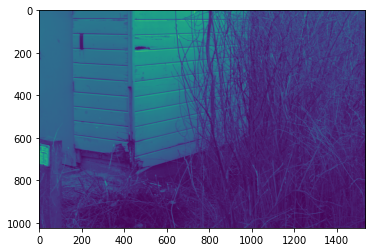

In [4]:
filename = DATA_DIR + "imk00110.imc"
img = load_image(filename)
plt.imshow(img)

In [5]:
def sample_patches_from_image(img, num=500, size=(3,3)):
    """Sample `num` patches of size `size` each from `img`
    Returns:
        patches: ndarray of shape (num, *size).
    """
    shape = img.shape
    anchor_x, anchor_y = [np.random.randint(0, shape_-size_, size=num) for shape_, size_ in zip(shape, size)]
    anchors_x = anchor_x[:, None, None] + np.arange(size[0])[None, :, None]
    anchors_y = anchor_y[:, None, None] + np.arange(size[1])[None, None, :]
    patches = img[anchors_x, anchors_y]
    return patches

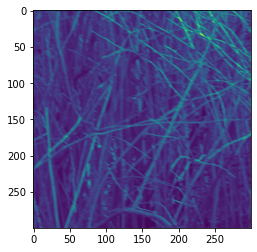

In [6]:
patches = sample_patches_from_image(img, 3, (300, 300))
plt.imshow(patches[0]) # Sample a bigger one to check if it's correct

## Extract all patches

In [7]:
files = glob(f"{DATA_DIR}*")

In [8]:
def load_image_and_extract_patches(filename, do_save=True):
    img = load_image(filename)
    patches = sample_patches_from_image(img, num=5000, size=(3,3))
    if do_save:
        save_to = f"{DATA_PATCHES}patches{filename[-9:-4]}.npy"
        np.save(save_to, patches)
    return patches

In [9]:
np.random.seed(0)
all_patches = [load_image_and_extract_patches(f, do_save=False) for f in files]

In [10]:
stacked_patches = np.stack(all_patches)
stacked_patches.shape

(4167, 5000, 3, 3)

In [11]:
np.save("./../../DATA/vanhateren/raw_patches.npy", stacked_patches)

## Preprocess and subset

In [3]:
D = np.array([[2, -1, 0, -1, 0, 0, 0, 0, 0],
              [-1, 3, -1, 0, -1, 0, 0, 0, 0],
              [0, -1, 2, 0, 0, -1, 0, 0, 0],
              [-1, 0, 0, 3, -1, 0, -1, 0, 0],
              [0, -1, 0, -1, 4, -1, 0, -1, 0],
              [0, 0, -1, 0, -1, 3, 0, 0, -1],
              [0, 0, 0, -1, 0, 0, 2, -1, 0],
              [0, 0, 0, 0, -1, 0, -1, 3, -1],
              [0, 0, 0, 0, 0, -1, 0, -1, 2]]).astype(float)

A = np.array([[1, 0, -1, 1, 0, -1, 1, 0, -1],
              [1, 1, 1, 0, 0, 0, -1, -1, -1],
              [1, -2, 1, 1, -2, 1, 1, -2, 1],
              [1, 1, 1, -2, -2, -2, 1, 1, 1],
              [1, 0, -1, 0, 0, 0, -1, 0, 1],
              [1, 0, -1, -2, 0, 2, 1, 0, -1],
              [1, -2, 1, 0, 0, 0, -1, 2, -1],
              [1, -2, 1, -2, 4, -2, 1, -2, 1]]).T
Lambda = 1/np.diag(A.T@A)
A = A/np.sqrt(np.array([6., 6., 54., 54., 8., 48., 48., 216.]))

def preprocess_extract(patches):
    """For patches from one image, preprocess them and return
    those with biggest D-norm.
    Params:
    -------
        patches: ndarray of shape (n, 9), a list of patches (from a single image).
    Return:
    -------
        points_new_basis: ndarray of shape (n//5, 8), pre-processed patches,
            with maximal D-norm, in the DCT basis."""
    n_points, dim = patches.shape
    
    centered = patches - np.mean(patches, axis=0)
    norms = np.diag(centered@(D@centered.T))
    top20_indices = np.argsort(-norms)[:n_points//5]
    top20 = centered[top20_indices]
    top20_normalized = top20/norms[top20_indices, None]
    points = top20_normalized
    points_new_basis = Lambda*(A.T@points.T).T
    
    return points_new_basis

In [13]:
new_patch = preprocess_extract(stacked_patches[0].reshape(-1, 9))
new_patch.shape

(1000, 8)

In [14]:
flattened_patches = stacked_patches.reshape(*stacked_patches.shape[0:2], 9)
selected_patches = np.stack([preprocess_extract(p)
                             for p in tqdm(flattened_patches)])

<ipython-input-14-cb9a79fbfa97>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for p in tqdm(flattened_patches)])


  0%|          | 0/4167 [00:00<?, ?it/s]

In [15]:
np.save("./../../DATA/vanhateren/patches.npy", selected_patches)

In [16]:
selected_patches.shape

(4167, 1000, 8)

## Generate Q

In [10]:
H = np.array([[-1, -1], [-1,  0], [-1,  1],
              [ 0, -1], [ 0,  0],  [ 0,  1],
              [ 1, -1], [ 1,  0], [ 1,  1]]).T

def get_polynomial_from_theta(theta, sign):
    ab = np.concatenate([np.cos(theta), np.sin(theta)], axis=1).T
    poly = sign[:, None]*(ab[0, :, None]*H[0, None, :] + ab[1, :, None]*H[1, None, :])
    return poly

def get_Q_bar(n_sample):
    theta, sign = 2*np.pi*np.random.rand(n_sample, 1), np.random.choice(np.array([-1, 1]), size=(n_sample,))
    q_bar = get_polynomial_from_theta(theta, sign)
    q_bar_new_basis = Lambda*(A.T@q_bar.T).T
    return q_bar_new_basis

def get_Q(points, n_sample, return_indices=False):
    """For each of the `n_sample` sampled points from \bar{Q}, return the point
    which is the closest.
    """
    q_bar_new_basis = get_Q_bar(n_sample)
    closest_points = np.argmin(cdist(q_bar_new_basis, points), axis=1)
    if return_indices:
        return closest_points
    else:
        return points[closest_points, :]

In [13]:
n_sample = 30
np.random.seed(0)

In [14]:
q_bar = get_Q_bar(n_sample)

In [9]:
np.save("./../data/Q_bar.npy", q_bar)

In [15]:
patches = np.load("./../../DATA/vanhateren/patches.npy")
points = patches.reshape(-1, 8)
close_points = get_Q(points=points, n_sample=30)

### Statistics on distances
